In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.layers import Flatten
import tensorflow as tf
from keras import layers

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
import pickle

In [3]:
from tensorflow.keras.layers import Bidirectional


In [4]:
# Define some variables
vocab_size = 5000 # Max number of words
embedding_dim = 64 # Word Vector dimension
max_length = 200 # Max length of the sequence
trunc_type = 'post' # where to chop off
padding_type = 'post' # where to put the padding
oov_tok = '<OOV>'

In [5]:
X = pd.read_csv(".../data/misc data/X.csv")
y = pd.read_csv(".../data/misc data/y.csv")

In [7]:
with open('X_test.pkl', 'rb') as f:
    X_test_model = pickle.load(f)

In [8]:
y.drop(columns=["Unnamed: 0"], inplace=True)

In [9]:
y.value_counts(normalize = True)

target
0         0.57377
1         0.42623
dtype: float64

In [10]:
X.drop(columns=["Unnamed: 0"], inplace=True)

In [11]:
tweets = []

for index, row in X.iterrows():

  token_list = [x for x in row['text'].split() if x not in stopwords.words('english')]

  tweets.append(" ".join(token_list))

In [12]:
yn = y.values.tolist()

In [13]:
Xn = tweets

In [14]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(Xn, yn, random_state = 42,
                                                    test_size = 0.2, stratify=y)

In [16]:
tokenizer.fit_on_texts(X_train)

In [17]:
train_seq = tokenizer.texts_to_sequences(X_train)

In [18]:
train_padded = pad_sequences(train_seq, maxlen=max_length, padding= padding_type,
                             truncating = trunc_type)
train_padded=np.array(train_padded)

In [19]:
test_seq = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_seq, maxlen = max_length, padding = padding_type,
                            truncating = trunc_type)
test_padded=np.array(test_padded)

In [20]:
testing_seq = tokenizer.texts_to_sequences(X_test_model)
testing_padded = pad_sequences(testing_seq, maxlen = max_length, padding = padding_type,
                            truncating = trunc_type)
testing_padded=np.array(testing_padded)

In [26]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
model.add(Bidirectional(LSTM(64, return_sequences = True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 64)           320000    
                                                                 
 bidirectional_2 (Bidirecti  (None, 200, 128)          66048     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 427329 (1.63 MB)
Trainable params: 427329 (1.63 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
from keras import backend as K

In [61]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

#stackexchange thread https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

In [62]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc',f1_m,precision_m, recall_m, specificity_m])

In [28]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [41]:
history = model.fit(train_padded, y_train, validation_data = (test_padded, y_test),
          batch_size = 256, epochs = 5)

Epoch 1/5
24/24 [==============================] - 60s 2s/step - loss: 0.1057 - acc: 0.9690 - f1_m: 0.9631 - precision_m: 0.9760 - recall_m: 0.9511 - specificity: 0.9822 - val_loss: 0.7626 - val_acc: 0.7742 - val_f1_m: 0.7326 - val_precision_m: 0.7367 - val_recall_m: 0.7292 - val_specificity: 0.8065
Epoch 2/5
24/24 [==============================] - 62s 3s/step - loss: 0.0858 - acc: 0.9755 - f1_m: 0.9709 - precision_m: 0.9812 - recall_m: 0.9611 - specificity: 0.9864 - val_loss: 0.8795 - val_acc: 0.7522 - val_f1_m: 0.7166 - val_precision_m: 0.6985 - val_recall_m: 0.7362 - val_specificity: 0.7622
Epoch 3/5
24/24 [==============================] - 62s 3s/step - loss: 0.0772 - acc: 0.9740 - f1_m: 0.9697 - precision_m: 0.9753 - recall_m: 0.9644 - specificity: 0.9819 - val_loss: 0.8458 - val_acc: 0.7688 - val_f1_m: 0.7143 - val_precision_m: 0.7517 - val_recall_m: 0.6811 - val_specificity: 0.8318
Epoch 4/5
24/24 [==============================] - 52s 2s/step - loss: 0.0698 - acc: 0.9768 - f1_

In [42]:
loss, accuracy, f1_score, precision, recall, specificity = model.evaluate(test_padded, y_test, verbose=0)

In [53]:
print(loss, accuracy, f1_score, precision, recall, specificity)

0.9703246355056763 0.756828784942627 0.709057092666626 0.7131274342536926 0.7203157544136047 0.7845596671104431


In [65]:
 df = pd.DataFrame(
        {'Model' : "Sequential, Bidirectional, LSTM",
         'Loss': round(loss,2),
        'Accuracy': round(accuracy,2),
         'Sensitivity': round(recall,2),
         'Specificity': round(specificity,2),
         'Precision' : round(precision,2),
         'F1 Score' : round(f1_score,2)
        },index=[0]
    )
df

,Model,Loss,Accuracy,Sensitivity,Specificity,Precision,F1 Score
0,"Sequential, Bidirectional, LSTM",0.97,0.76,0.72,0.78,0.71,0.71


In [ ]:
model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
model1.add(LSTM(32, return_sequences = True))
model1.add(Bidirectional(LSTM(16)))
model1.add(Dense(1, activation = 'sigmoid'))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 64)           320000    
                                                                 
 lstm_2 (LSTM)               (None, 200, 32)           12416     
                                                                 
 bidirectional_2 (Bidirecti  (None, 32)                6272      
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 338721 (1.29 MB)
Trainable params: 338721 (1.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc',f1_m,precision_m, recall_m, specificity])

In [ ]:
model1.fit(train_padded, y_train, validation_data = (test_padded, y_test),
          batch_size = 256, epochs = 5)

Epoch 1/5
24/24 [==============================] - 18s 574ms/step - loss: 0.6792 - acc: 0.5708 - val_loss: 0.6610 - val_acc: 0.5736
Epoch 2/5
24/24 [==============================] - 9s 366ms/step - loss: 0.5807 - acc: 0.7021 - val_loss: 0.4800 - val_acc: 0.8068
Epoch 3/5
24/24 [==============================] - 7s 283ms/step - loss: 0.4032 - acc: 0.8524 - val_loss: 0.4435 - val_acc: 0.8128
Epoch 4/5
24/24 [==============================] - 9s 381ms/step - loss: 0.3131 - acc: 0.8967 - val_loss: 0.4643 - val_acc: 0.8081
Epoch 5/5
24/24 [==============================] - 8s 337ms/step - loss: 0.2525 - acc: 0.9217 - val_loss: 0.5012 - val_acc: 0.8001


In [ ]:
model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
model2.add(Bidirectional(tf.keras.layers.GRU(16)))
model2.add(Dense(1, activation = 'sigmoid'))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 64)           320000    
                                                                 
 bidirectional_3 (Bidirecti  (None, 32)                7872      
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 327905 (1.25 MB)
Trainable params: 327905 (1.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc'])

In [ ]:
model2.fit(train_padded, y_train, validation_data = (test_padded, y_test),
          batch_size = 256, epochs = 5)

Epoch 1/5
24/24 [==============================] - 7s 180ms/step - loss: 0.6769 - acc: 0.5736 - val_loss: 0.6638 - val_acc: 0.5736
Epoch 2/5
24/24 [==============================] - 4s 184ms/step - loss: 0.6350 - acc: 0.6248 - val_loss: 0.6005 - val_acc: 0.7015
Epoch 3/5
24/24 [==============================] - 7s 277ms/step - loss: 0.5116 - acc: 0.7837 - val_loss: 0.4694 - val_acc: 0.8041
Epoch 4/5
24/24 [==============================] - 8s 317ms/step - loss: 0.3668 - acc: 0.8539 - val_loss: 0.4325 - val_acc: 0.8055
Epoch 5/5
24/24 [==============================] - 6s 240ms/step - loss: 0.2931 - acc: 0.8859 - val_loss: 0.4416 - val_acc: 0.8008


In [58]:
model3 = Sequential()
model3.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
model3.add(Bidirectional(tf.keras.layers.GRU(16)))
model3.add(Dense(8, activation = 'relu'))
model3.add(Dense(1, activation = 'sigmoid'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 64)           320000    
                                                                 
 bidirectional_4 (Bidirecti  (None, 32)                7872      
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 328145 (1.25 MB)
Trainable params: 328145 (1.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [63]:
model3.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc',f1_m,precision_m, recall_m, specificity_m])

In [64]:
history3 = model3.fit(train_padded, y_train, validation_data = (test_padded, y_test),
          batch_size = 256, epochs = 5)

Epoch 1/5
24/24 [==============================] - 17s 514ms/step - loss: 0.6735 - acc: 0.5743 - f1_m: 0.0281 - precision_m: 0.1612 - recall_m: 0.0188 - specificity_m: 0.9885 - val_loss: 0.6518 - val_acc: 0.6056 - val_f1_m: 0.1381 - val_precision_m: 1.0000 - val_recall_m: 0.0745 - val_specificity_m: 1.0000
Epoch 2/5
24/24 [==============================] - 14s 568ms/step - loss: 0.6021 - acc: 0.6988 - f1_m: 0.4519 - precision_m: 0.9492 - recall_m: 0.3177 - specificity_m: 0.9818 - val_loss: 0.5416 - val_acc: 0.7755 - val_f1_m: 0.6797 - val_precision_m: 0.8583 - val_recall_m: 0.5643 - val_specificity_m: 0.9300
Epoch 3/5
24/24 [==============================] - 9s 390ms/step - loss: 0.4345 - acc: 0.8327 - f1_m: 0.7819 - precision_m: 0.8747 - recall_m: 0.7118 - specificity_m: 0.9211 - val_loss: 0.4499 - val_acc: 0.8008 - val_f1_m: 0.7607 - val_precision_m: 0.7737 - val_recall_m: 0.7487 - val_specificity_m: 0.8388
Epoch 4/5
24/24 [==============================] - 7s 297ms/step - loss: 0.31

In [73]:
loss3, accuracy3, f1_score3, precision3, recall3, specificity3 = model3.evaluate(test_padded, y_test, verbose=0)

In [77]:
  df3 = pd.DataFrame(
        {'Model' : "Sequential, Bidirectional, GRU",
         'Loss': round(loss3,2),
        'Accuracy': round(accuracy3,2),
         'Sensitivity': round(recall3,2),
         'Specificity': round(specificity3,2),
         'Precision' : round(precision3,2),
         'F1 Score' : round(f1_score3,2)
        },index=[0]
    )
df3

,Model,Loss,Accuracy,Sensitivity,Specificity,Precision,F1 Score
0,"Sequential, Bidirectional, GRU",0.5,0.8,0.71,0.86,0.79,0.74


In [68]:
model4 = Sequential()
model4.add(Embedding(vocab_size, 32, input_length = max_length))
model4.add(Bidirectional(tf.keras.layers.GRU(16)))
model4.add(Dense(8, activation = 'relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model4.add(Dense(1, activation = 'sigmoid'))

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 32)           160000    
                                                                 
 bidirectional_5 (Bidirecti  (None, 32)                4800      
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 8)                 264       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 165073 (644.82 KB)
Trainable params: 165073 (644.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [70]:
model4.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc',f1_m,precision_m, recall_m, specificity_m])

In [71]:
history4 = model4.fit(train_padded, y_train, validation_data = (test_padded, y_test),
          batch_size = 256, epochs = 5)

Epoch 1/5
24/24 [==============================] - 17s 508ms/step - loss: 0.7983 - acc: 0.5730 - f1_m: 0.0056 - precision_m: 0.0170 - recall_m: 0.0034 - specificity_m: 0.9948 - val_loss: 0.7789 - val_acc: 0.5736 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_specificity_m: 1.0000
Epoch 2/5
24/24 [==============================] - 11s 470ms/step - loss: 0.7600 - acc: 0.5751 - f1_m: 0.0080 - precision_m: 0.2083 - recall_m: 0.0041 - specificity_m: 1.0000 - val_loss: 0.7351 - val_acc: 0.6049 - val_f1_m: 0.1340 - val_precision_m: 1.0000 - val_recall_m: 0.0726 - val_specificity_m: 1.0000
Epoch 3/5
24/24 [==============================] - 10s 400ms/step - loss: 0.6853 - acc: 0.6784 - f1_m: 0.3924 - precision_m: 0.9801 - recall_m: 0.2560 - specificity_m: 0.9949 - val_loss: 0.6377 - val_acc: 0.7322 - val_f1_m: 0.5524 - val_precision_m: 0.9592 - val_recall_m: 0.3885 - val_specificity_m: 0.9871
Epoch 4/5
24/24 [==============================] - 6s 257ms/step

In [72]:
loss4, accuracy4, f1_score4, precision4, recall4, specificity4 = model4.evaluate(test_padded, y_test, verbose=0)

In [78]:
  df4 = pd.DataFrame(
        {'Model' : "Sequential, Bidirectional, GRU, Regularization",
         'Loss': round(loss4,2),
        'Accuracy': round(accuracy4,2),
         'Sensitivity': round(recall4,2),
         'Specificity': round(specificity4,2),
         'Precision' : round(precision4,2),
         'F1 Score' : round(f1_score4,2)
        },index=[0]
    )
df4

,Model,Loss,Accuracy,Sensitivity,Specificity,Precision,F1 Score
0,"Sequential, Bidirectional, GRU, Regularization",0.51,0.81,0.73,0.87,0.8,0.76


In [ ]:
with open('Model.pkl', 'wb') as f:
    pickle.dump(history4, f)

In [92]:
from keras.callbacks import EarlyStopping


In [93]:
es = EarlyStopping(monitor='val_acc', mode='min', verbose=1, patience=5, baseline=0.57)

In [ ]:
model5 = Sequential()
model5.add(Embedding(vocab_size, 64, input_length = max_length))
model5.add(Bidirectional(tf.keras.layers.GRU(32)))
model5.add(Dense(16, activation = 'relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model5.add(Dense(1, activation = 'sigmoid'))

model5.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 64)           320000    
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                18816     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 339873 (1.30 MB)
Trainable params: 339873 (1.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model5.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc'])

In [ ]:
history5 = model5.fit(train_padded, y_train, validation_data = (test_padded, y_test),
          batch_size = 256, epochs = 5, callbacks=[es])

Epoch 1/5
24/24 [==============================] - 10s 283ms/step - loss: 0.9027 - acc: 0.5740 - val_loss: 0.8586 - val_acc: 0.5736
Epoch 2/5
24/24 [==============================] - 7s 291ms/step - loss: 0.7922 - acc: 0.6301 - val_loss: 0.7100 - val_acc: 0.7408
Epoch 3/5
24/24 [==============================] - 6s 258ms/step - loss: 0.5888 - acc: 0.8256 - val_loss: 0.5832 - val_acc: 0.8155
Epoch 4/5
24/24 [==============================] - 7s 297ms/step - loss: 0.4296 - acc: 0.8774 - val_loss: 0.5655 - val_acc: 0.8081
Epoch 5/5
24/24 [==============================] - 6s 258ms/step - loss: 0.3422 - acc: 0.9075 - val_loss: 0.5884 - val_acc: 0.8021
Epoch 5: early stopping


In [87]:
import matplotlib.pyplot as plt

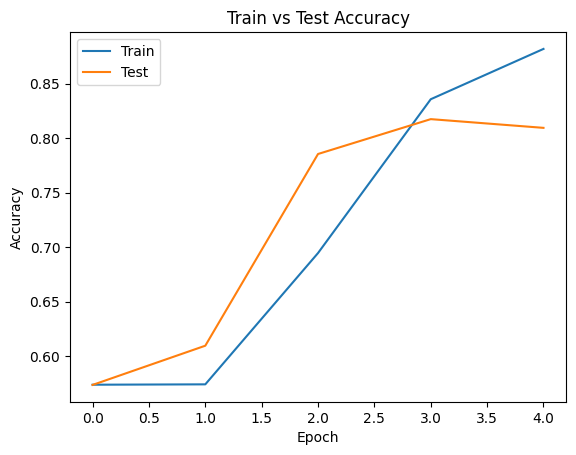

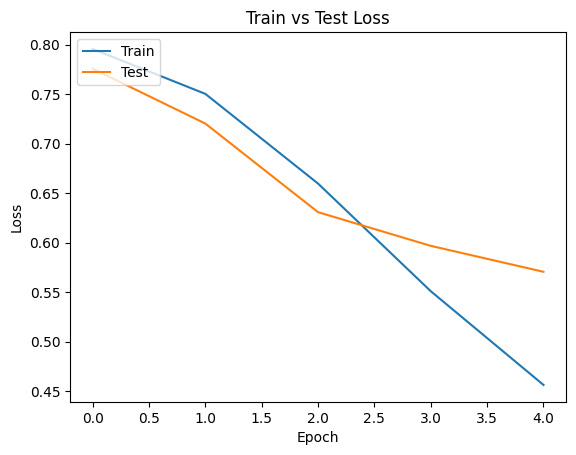

In [ ]:
# summarize history for accuracy
plt.plot(history4.history['acc'])
plt.plot(history4.history['val_acc'])
plt.title('Train vs Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Train vs Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Word2Vec

In [79]:
import gensim
from gensim.models import Word2Vec

In [80]:
type(X)

pandas.core.frame.DataFrame

In [81]:
tweets_w2v = []

for index, row in X.iterrows():

  token_list = [x for x in row['text'].split() if x not in stopwords.words('english')]

  tweets_w2v.append(token_list)
#tweets_w2v

In [82]:
w2v = gensim.models.Word2Vec(tweets_w2v, min_count = 1,vector_size = 200, window = 5,  min_alpha = 0.025)

In [83]:
vocabulary = list(w2v.wv.key_to_index)

def vectorize(text_):
    words = text_
    words_vecs = [w2v.wv[word] for word in words if word in vocabulary]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)
Xn_w2v = np.array([vectorize(text_) for text_ in tweets_w2v])

In [ ]:
w2v.train(tweets_w2v, total_examples=len(tweets_w2v), epochs=10)

(663381, 666120)

In [ ]:
w1 = "shot"
w2v.wv.most_similar(positive = w1, topn=5)

[('tak', 0.9751924872398376),
 ('#emmerdale', 0.9748029112815857),
 ('opportunity', 0.9740111827850342),
 ('porridge', 0.9727528691291809),
 ('rioting', 0.9724295735359192)]

In [89]:
model6 = Sequential()
model6.add(Embedding(len(tweets_w2v)+1, embedding_dim, input_length = max_length))
model6.add(Bidirectional(tf.keras.layers.GRU(16)))
model6.add(Dense(8, activation = 'relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model6.add(Flatten())
model6.add(Dense(1, activation = 'sigmoid'))

model6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 200, 64)           480256    
                                                                 
 bidirectional_7 (Bidirecti  (None, 32)                7872      
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 8)                 264       
                                                                 
 flatten_1 (Flatten)         (None, 8)                 0         
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 488401 (1.86 MB)
Trainable params: 488401 (1.86 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [94]:
model6.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc',f1_m,precision_m, recall_m, specificity_m])

In [95]:
history6 = model6.fit(train_padded, y_train, validation_data = (test_padded, y_test),
          batch_size = 256, epochs = 5, callbacks=[es])

Epoch 1/5
24/24 [==============================] - 17s 502ms/step - loss: 0.8085 - acc: 0.5746 - f1_m: 0.0091 - precision_m: 0.0652 - recall_m: 0.0053 - specificity_m: 0.9970 - val_loss: 0.7874 - val_acc: 0.5736 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_specificity_m: 1.0000
Epoch 2/5
24/24 [==============================] - 15s 649ms/step - loss: 0.7653 - acc: 0.5750 - f1_m: 0.0064 - precision_m: 0.1667 - recall_m: 0.0033 - specificity_m: 1.0000 - val_loss: 0.7371 - val_acc: 0.5963 - val_f1_m: 0.0983 - val_precision_m: 1.0000 - val_recall_m: 0.0523 - val_specificity_m: 1.0000
Epoch 3/5
24/24 [==============================] - 11s 449ms/step - loss: 0.6739 - acc: 0.7001 - f1_m: 0.4531 - precision_m: 0.9668 - recall_m: 0.3227 - specificity_m: 0.9879 - val_loss: 0.6067 - val_acc: 0.7895 - val_f1_m: 0.6930 - val_precision_m: 0.9056 - val_recall_m: 0.5633 - val_specificity_m: 0.9580
Epoch 4/5
24/24 [==============================] - 15s 643ms/ste

In [96]:
loss6, accuracy6, f1_score6, precision6, recall6, specificity6 = model6.evaluate(test_padded, y_test, verbose=0)

In [98]:
  df6 = pd.DataFrame(
        {'Model' : "Sequential, Word2Vec, EarlyStopping",
         'Loss': round(loss6,2),
        'Accuracy': round(accuracy6,2),
         'Sensitivity': round(recall6,2),
         'Specificity': round(specificity6,2),
         'Precision' : round(precision6,2),
         'F1 Score' : round(f1_score6,2)
        },index=[0]
    )
df6

,Model,Loss,Accuracy,Sensitivity,Specificity,Precision,F1 Score
0,"Sequential, Word2Vec, EarlyStopping",0.52,0.81,0.71,0.87,0.81,0.75


In [100]:
Comparison = pd.concat([df, df3, df4, df6],ignore_index=True)
Comparison

,Model,Loss,Accuracy,Sensitivity,Specificity,Precision,F1 Score
0,"Sequential, Bidirectional, LSTM",0.97,0.76,0.72,0.78,0.71,0.71
1,"Sequential, Bidirectional, GRU",0.50,0.80,0.71,0.86,0.79,0.74
2,"Sequential, Bidirectional, GRU, Regularization",0.51,0.81,0.73,0.87,0.80,0.76
3,"Sequential, Word2Vec, EarlyStopping",0.52,0.81,0.71,0.87,0.81,0.75


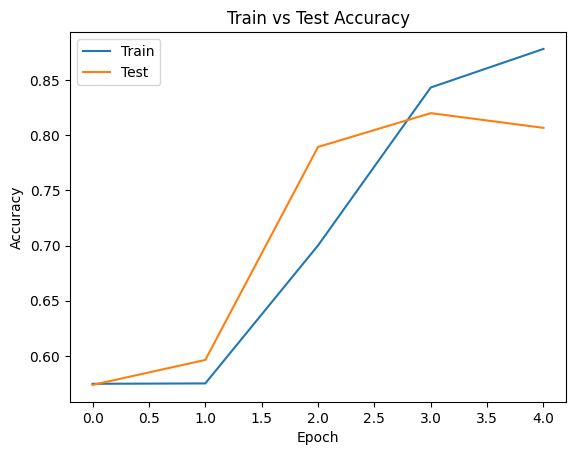

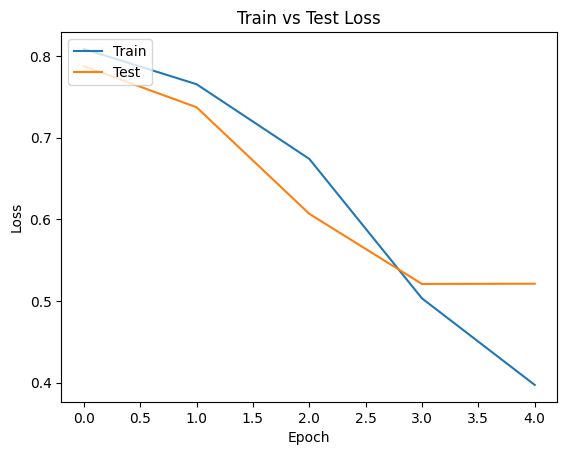

In [101]:
# summarize history for accuracy
plt.plot(history6.history['acc'])
plt.plot(history6.history['val_acc'])
plt.title('Train vs Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('Train vs Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
import pickle

In [ ]:
with open('X_test.pkl', 'rb') as f:
    X_test_in_model = pickle.load(f)

### Glove

In [ ]:
embedding_matrix_vocab = np.zeros(((vocab_size+1),embedding_dim))
embeddings_index = {}
file = "glove.twitter.27B.200d.txt"
for line in file:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
##https://www.geeksforgeeks.org/pre-trained-word-embedding-using-glove-in-nlp-models/

In [ ]:
model7 = Sequential()
model7.add(Embedding((vocab_size+1), embedding_dim, input_length = max_length))
model7.add(Bidirectional(tf.keras.layers.GRU(16)))
model7.add(Dense(8, activation = 'relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model7.add(Flatten())
model7.add(Dense(1, activation = 'sigmoid'))

model7.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 200, 64)           320064    
                                                                 
 bidirectional_11 (Bidirect  (None, 32)                7872      
 ional)                                                          
                                                                 
 dense_17 (Dense)            (None, 8)                 264       
                                                                 
 flatten_4 (Flatten)         (None, 8)                 0         
                                                                 
 dense_18 (Dense)            (None, 1)                 9         
                                                                 
Total params: 328209 (1.25 MB)
Trainable params: 328209 (1.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [ ]:
model7.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc'] )

In [ ]:
history7 = model7.fit(train_padded, y_train, validation_data = (test_padded, y_test),
          batch_size = 256, epochs = 5, callbacks=[es])

Epoch 1/5
24/24 [==============================] - 9s 203ms/step - loss: 0.7992 - acc: 0.5738 - val_loss: 0.7754 - val_acc: 0.5736
Epoch 2/5
24/24 [==============================] - 4s 158ms/step - loss: 0.7354 - acc: 0.6203 - val_loss: 0.6955 - val_acc: 0.6902
Epoch 3/5
24/24 [==============================] - 6s 238ms/step - loss: 0.6210 - acc: 0.7697 - val_loss: 0.6152 - val_acc: 0.8001
Epoch 4/5
24/24 [==============================] - 4s 159ms/step - loss: 0.5117 - acc: 0.8632 - val_loss: 0.5954 - val_acc: 0.8081
Epoch 5/5
24/24 [==============================] - 4s 159ms/step - loss: 0.4216 - acc: 0.8980 - val_loss: 0.5762 - val_acc: 0.8075
Epoch 5: early stopping


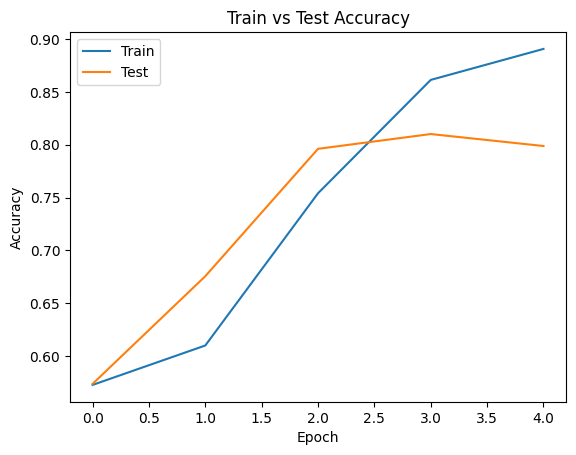

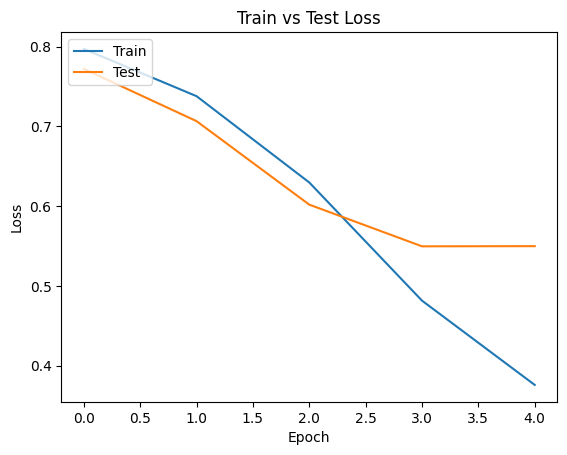

In [ ]:
# summarize history for accuracy
plt.plot(history7.history['acc'])
plt.plot(history7.history['val_acc'])
plt.title('Train vs Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('Train vs Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model8 = Sequential()
model8.add(Embedding((vocab_size+1), embedding_dim, input_length = max_length))
model8.add(Bidirectional(tf.keras.layers.GRU(64)))
model8.add(Dense(16, activation = 'relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model8.add(Flatten())
model8.add(Dense(1, activation = 'sigmoid'))

In [ ]:
model8.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc'])

In [ ]:
history8 = model8.fit(train_padded, y_train, validation_data = (test_padded, y_test),
          batch_size = 256, epochs = 5, callbacks=[es])

Epoch 1/5
24/24 [==============================] - 17s 559ms/step - loss: 0.9180 - acc: 0.5715 - val_loss: 0.8588 - val_acc: 0.5736
Epoch 2/5
24/24 [==============================] - 14s 583ms/step - loss: 0.7698 - acc: 0.6719 - val_loss: 0.6575 - val_acc: 0.7642
Epoch 3/5
24/24 [==============================] - 12s 505ms/step - loss: 0.5054 - acc: 0.8399 - val_loss: 0.5536 - val_acc: 0.8001
Epoch 4/5
24/24 [==============================] - 13s 534ms/step - loss: 0.3765 - acc: 0.8859 - val_loss: 0.5621 - val_acc: 0.8075
Epoch 5/5
24/24 [==============================] - 14s 569ms/step - loss: 0.2916 - acc: 0.9170 - val_loss: 0.5952 - val_acc: 0.7901
Epoch 5: early stopping


### Evaluation

47/47 [==============================] - 13s 179ms/step
TN: 645
FP: 216
FN: 142
TP: 498
Sensitivity: 0.778125
Specificity: 0.7491289198606271
Validation Accuracy: 0.7614923384410394


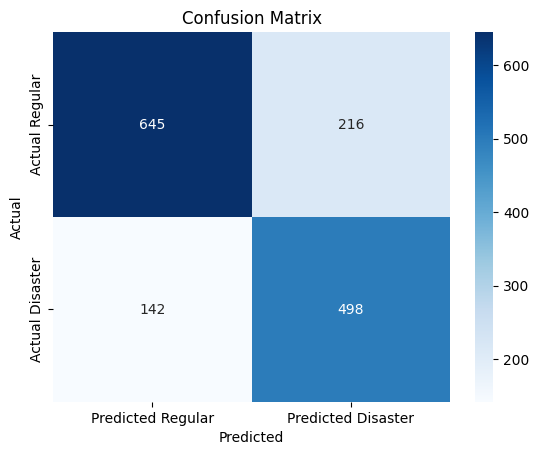

<ipython-input-37-6f0ddcffe7c4>:29: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')


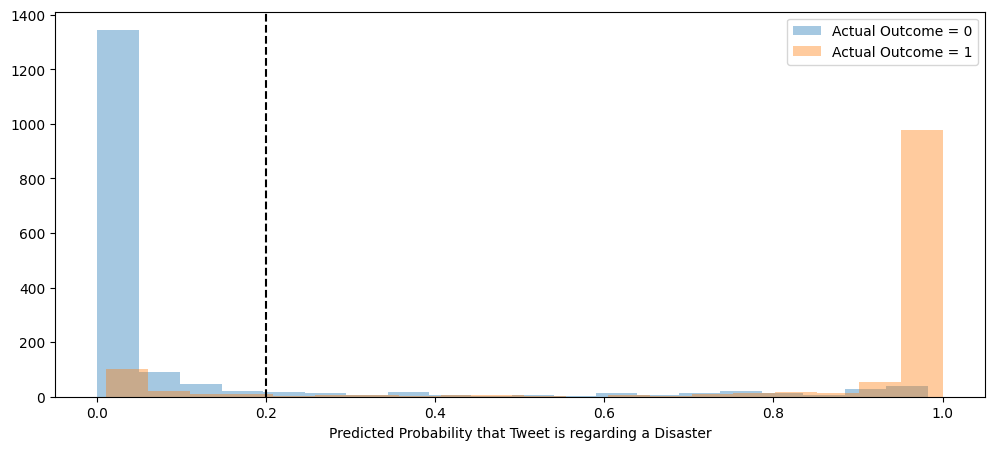

In [ ]:
def keras_evaluations(model, X_test_in_model, y_test_truth, decision_boundary=0.2):

  predict_probs = model.predict(X_test_in_model)

  preds = (predict_probs > decision_boundary).astype(int)

  conf_matrix = confusion_matrix(y_test_truth, preds)

  tn, fp, fn, tp = conf_matrix.ravel()

  print(f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}")

  print(f"Sensitivity: {tp/(tp+fn)}\nSpecificity: {tn/(tn + fp)}\nValidation Accuracy: {(tp+tn)/(tp+tn+fp+fn)}")

  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Regular', 'Predicted Disaster'], yticklabels=['Actual Regular', 'Actual Disaster'])
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()

  reshaped_probs = [l[0] for l in predict_probs]
  reshaped_y_test = [l[0] for l in y_test_truth]

  pred_df = pd.DataFrame({'true_values': reshaped_y_test, 'pred_probs': reshaped_probs})

  plt.figure(figsize = (12, 5))
  # plot distributions of predicted probabilities by actual values
  for group in pred_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

  # Add cutoff line
  plt.axvline(decision_boundary, color = 'black', linestyle = '--')

  plt.xlabel('Predicted Probability that Tweet is regarding a Disaster')
  plt.legend();

keras_evaluations(model, test_padded, y_test)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, RocCurveDisplay, roc_auc_score, recall_score, precision_score, f1_score